# Dogs vs cats

This notebook utilises the VGG 16 model (winner of the 2016 imagenet comptetion) to do classicifation on the Kaggle cats vs. dogs dataset.

We start by setting up the data in the right folder structure. Next we set up the VGG 16 model (they did a slower VGG 19 model as well) using Keras with Theano backend.

## Setting up the right folder structure

Assumed dataset is from the Kaggle [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

Unzipping the data yields this folder structure:
```
train/
    cat.437.jpg
    dog.9924.jpg
    cat.1029.jpg
    dog.4374.jpg
test/
    231.jpg
    325.jpg
    1235.jpg
    9923.jpg
```
Working directory is root of this folder structure.

We then start by creating the desired folder structure. First setup relevant path names that will be utilised repeatedly:

In [145]:
import os, sys

current_dir = os.getcwd()
DATA_HOME_DIR = current_dir

# Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

Next we create the top directories

In [ ]:
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

Then we create the cat/dog subfolders of each relevant directory.

In [ ]:
%cd $DATA_HOME_DIR/sample/train
%mkdir cat
%mkdir dog

%cd $DATA_HOME_DIR/sample/valid
%mkdir cat
%mkdir dog

%cd $DATA_HOME_DIR/valid
%mkdir cat
%mkdir dog

%cd $DATA_HOME_DIR/train
%mkdir cat
%mkdir dog

Then we start by moving the test data.

In [ ]:
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

Then we move the training data.

In [ ]:
%cd $DATA_HOME_DIR/train

%mv cat.* cat
%mv dog.* dog

Then we move into the validation folder and sample train and validation folder

In [ ]:
%cd $DATA_HOME_DIR/train/cat
shuf -n 1000 -e * | xargs -i mv {} $DATA_HOME_DIR/valid/cat

%cd $DATA_HOME_DIR/train/dog
shuf -n 1000 -e * | xargs -i mv {} $DATA_HOME_DIR/valid/dog

%cd $DATA_HOME_DIR/train/cat
shuf -n 100 -e * | xargs -i mv {} $DATA_HOME_DIR/sample/train/cat

%cd $DATA_HOME_DIR/train/dog
shuf -n 100 -e * | xargs -i mv {} $DATA_HOME_DIR/sample/train/dog

%cd $DATA_HOME_DIR/valid/cat
shuf -n 20 -e * | xargs -i mv {} $DATA_HOME_DIR/sample/valid/cat

%cd $DATA_HOME_DIR/valid/dog
shuf -n 20 -e * | xargs -i mv {} $DATA_HOME_DIR/sample/valid/dog

This completes the folder setup

## VGG 16 model set up

Start by importing libraries.

In [17]:
%matplotlib inline

import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

import json
import re
import itertools

Use a custom plotting function to plot images and labels

In [18]:
def plots(ims, figsize=(12, 6), rows = 1, interp = False, titles = None):
    
    if type(ims[0]) is np.ndarray:
        
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
            
    f = plt.figure(figsize = figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i + 1)
        sp.axis('Off')
        
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
            
        plt.imshow(ims[i], interpolation = None if interp else 'none')

Use a custom function to plot confusion matrix

In [19]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Import the mappings from VGG ids to imagenet category ids and descriptions. (For display purposes later). The mappings are taken from the fast.ai website.

In [20]:
files_path = 'http://files.fast.ai/models/'
class_file = 'imagenet_class_index.json'

# Keras' get_file() downloads files, and caches them for re-use later
fpath = get_file(class_file, files_path + class_file, cache_subdir = 'models')

with open(fpath) as f:
    class_dict = json.load(f)
    
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Examples of the categories just imported.

In [21]:
classes[0:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Creating the VGG 16 model

This is basically creating the model architecture, and then loading the model weights into that architecture. We start by creating the basic building blocks for the architecture.

VGG 16 has just one type of convolutional block, and one type of fully connected ('dense') block.

We start with the convolutional block definition:

In [22]:
def ConvBlock(layers, model, filters):
    
    for i in range(layers): 
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation = 'relu'))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

Then the fully connected block:

In [23]:
def FCBlock(model):
    
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [24]:
# Mean of each channel as provided by VGG researchers (i.e. hard coded)
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))

def vgg_preprocess(x):
    
    x = x - vgg_mean # subtract mean
    return x[:, ::-1] # reverse axis bgr->rgb

We then define the VGG model architecture

In [25]:
def VGG_16():
    
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1000, activation='softmax'))
    
    return model

We then crate our VGG 16 object

In [26]:
model = VGG_16()

We then download the VGG 16 weights. (We could do this ourselfs on the (huge) imagenet dataset)

In [27]:
fpath = get_file('vgg16.h5', files_path + 'vgg16.h5', cache_subdir = 'models')

# Assign the weights
model.load_weights(fpath)

## Runnning the model

We run the model in batches of the data, so as not to run out of memory

In [28]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images. All we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch.

This wrapper define some helpful defaults appropriate for imagenet data:

In [29]:
def get_batches(path, gen = image.ImageDataGenerator(), shuffle = True,
                batch_size = batch_size, class_mode = 'categorical'):
    
    return gen.flow_from_directory(path, target_size = (224, 224),
                                   class_mode = class_mode, shuffle = shuffle,
                                   batch_size = batch_size)

We can use the wrappers to look at predictions from the model

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


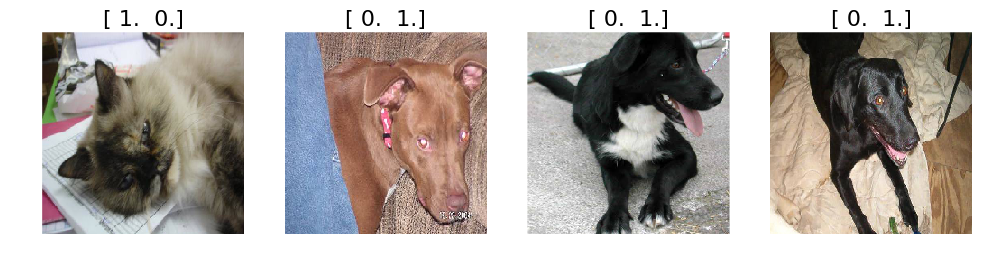

In [30]:
batches = get_batches('train', batch_size = batch_size)
val_batches = get_batches('valid', batch_size = batch_size)
imgs, labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles = labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with np.argmax()) we can find the predicted label.

We do this, with a pred_batch function wrapper.

In [31]:
def pred_batch(model, imgs):
    
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [32]:
pred_batch(model, imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.09969768e-07   1.52268512e-06   1.25300699e-06   4.07949926e-07
   9.49668291e-08]

Predictions prob/class: 
  0.6644/keeshond
  0.6429/vizsla
  0.3243/Border_collie
  0.6705/flat-coated_retriever


## Finetuning the VGG 16 model

Of course we are only interested in predicting the binary outcome cats/dogs. As such we need to finetune the VGG 16 model to output just these two classes instead of 1000 classes.

We define a finetune function that extens the basic VGG 16 model. First a function that replaces the last layer of the model with a dense (fully connected) layer of num neurons. We also lock the weights of all layers except the new layer so that we only learn weights for the last layer in subsequent training.

In [33]:
def ft(model, num):
    
    model.pop()
    
    for layer in model.layers: layer.trainable = False
    
    model.add(Dense(num, activation='softmax'))

    return model

We then define another finetune function that modifies the original VGG 16 network architecture and updates the model for new training data

In [34]:
def finetune(model, batches):
    
    model = ft(model, batches.nb_class)
    
    return model

## Running the finetuned model

We then run the finetuned model by compiling it:

In [35]:
model = finetune(model, batches)

model.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Redefine the batches, with a bigger batch size.

In [36]:
batch_size = 64

batches = get_batches('train', batch_size = batch_size)
val_batches = get_batches('valid', batch_size = batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Next we fit the model to the training and validation data

In [37]:
model.fit_generator(batches, samples_per_epoch = batches.nb_sample, nb_epoch = 1,
                    validation_data = val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 608s - loss: 0.1173 - acc: 0.9689 - val_loss: 0.0854 - val_acc: 0.9780


## Predicting on test data

Finally we can run our predictions on the test data. We write a simple wrapping function to do this.

In [ ]:
def test(model, path, batch_size = 8):
    
    test_batches = get_batches(path, shuffle = False, batch_size = batch_size, class_mode = None)
    
    return test_batches, model.predict_generator(test_batches, test_batches.nb_sample)

In [ ]:
val_batches, val_predictions = test(model, 'valid')
batches, predictions = test(model, 'test')

Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


Plot confusion matrix of our images

In [ ]:
cm = confusion_matrix(val_batches.classes, np.round(1 - val_predictions[:, 0]))
plot_confusion_matrix(cm, val_batches.class_indices)

Get file names for id extraction, extract dog value with rounded edge cases and stack in array.

In [ ]:
ids = [int(re.search('[^/]*(?=\.[^.]+($|\?))', idx).group(0)) for idx in batches.filenames]
isDog = predictions[:, 1].clip(min = 0.05, max = 0.95)

subm = np.stack([ids, isDog], axis = 1)

Save submission file

In [142]:
submission_file_name = 'submission2.csv'
np.savetxt(submission_file_name, subm, fmt = '%d,%.5f', header='id,label', comments='')

Make the dataset available for download

In [2]:
from IPython.display import FileLink
FileLink('submission1.csv')

/home/ubuntu/kaggle/dogs-vs-cats-redux-kernels-edition/submission1.csv